# Work Sample: US Stock Market Forecasting

### Author: Leopoldo Carbajal (leo.carbajalg@gmail.com)

## Summary:

The [intrinsic complex, multi-scaled dynamics of the stock market](https://doi.org/10.1371/journal.pone.0139420) pose a huge challenge even for experienced profesionals in finances. Thus, advance tools from Machine Leanrning (ML) such as [Recurrent Neural Networks (RNN)](https://youtu.be/_h66BW-xNgk) provide to be useful for implementing **less risky, successful investment strategies**.

Different RNNs with Long Short Term Memory (LSTM) cells are build and trained with daily data of hundreads of companies listed on the NYSE to produce a simple, yet powerful prototype of a forecasting tool for daily stock prices of companies. This shows that **forecasting the US stock market is possible, and paves the way for further iterations with refinements and improvements of the models used in this notebook**.


The predictions of the resulting RNN for predicting next day's open price of **Booking Holdings Inc.**, which is chosen based on the analysis presented in [THIS SECTION](#quick_analysis), closely follow the actual daily prices/trends, as show in the [comparison section](#comparison).

We organize the notebook as follows:

- First, we perform a [quick analysis of stock prices](#quick_analysis) to determine which companies have shown continuous growth in the last days. From these companies we choose the one with better performance as the target company for the price forecasting in this notebook. 
- Then, functions for [data preparation](#data_preparation) and [correlation analysis](#correlation_analysis) for [feature selection](https://doi.org/10.1007/978-0-387-30164-8_306) are implemented. 
- Finally, we [implemet multiple RNNs](#rnn_implementation), performing a [hyperparameter optimization](#hyperparams_optimization) to obtain the best possible RNN.

A [final analysis and discussion](#discussion) is shown at the end of the notebook.


## Implementation:

In the cell below we load all the python libraries that will be used in the notebook.

In [1]:
# Various libraries
import pandas as pd
import numpy as np
import os
from datetime import datetime
import platform
import multiprocessing
import time
import gc
import shutil
import warnings
import pickle as pk
import sys

pd.set_option('max_columns',500)
pd.set_option('max_rows',500)

# ML libraries
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers

# Load the TensorBoard notebook extension
%load_ext tensorboard

%load_ext memory_profiler

# Style, display
from IPython.display import HTML, display, Image

# Plotting
import matplotlib.pyplot as plt

print('TensorFlow version: ', tf.__version__)

TensorFlow version:  2.2.0


When running this notebook in a computer with limited resources, clearing the keras backend cache from time to time proves to be useful. The function below clears the keras backend and calls the python trash collector.

In [2]:
def flush_memory():
    keras.backend.clear_session()
    gc.collect()

We keep relevant information of the implementation in a dictionary in the format of metadata. This is specially helpful when debugging.

In [3]:
metadata = dict()

metadata['CPU_COUNT'] = multiprocessing.cpu_count()

print("Number of CPUs: ", metadata['CPU_COUNT'])

Number of CPUs:  4


TensorFlow optimizes the usage of resources by using [multi-threading](https://www.tensorflow.org/api_docs/python/tf/config/threading) when possible, it is a good idea to fine-tune the number of threads per inter and intra operations. In the system used to run this notebook (4 cores) we find that the training processes is faster when using 2 threads for both inter and intra operations.

In [4]:
# Set number of threads for inter operations
tf.config.threading.set_inter_op_parallelism_threads(2)

# Set number of threads for intra operations
tf.config.threading.set_intra_op_parallelism_threads(2)

We double check that the changes in the TensorFlow multi-threading configuration has been done correctly.

In [5]:
print('Threads for operation', tf.config.threading.get_inter_op_parallelism_threads())

print('Threads per operation', tf.config.threading.get_intra_op_parallelism_threads())

Threads for operation 2
Threads per operation 2


We want to keep to the minimum the messages displayed by TensorFlow, when training multiple networks these messages can become overwhelming.

In [6]:
# Set verbosity
tf.get_logger().setLevel('WARNING')

---

## Project Directories

It is a good practice to keep everything (input data, metadata, logs, model data, etc.) as tidy as possible. For this, we keep different data separate in different folders defined below.


In [7]:
metadata['CWD'] = os.getcwd()

# Dictionaries with constituents info
metadata['DICTIONARIES_PATH'] = os.path.join(metadata['CWD'],'dictionaries')

# Folder of processed data used for training
metadata['PROCESSED_DATA_PATH'] = os.path.join(metadata['CWD'],'processed_data')

# Production data folder 
metadata['PRODUCTION_DATA_PATH'] = os.path.join(metadata['CWD'],'production_data')

# Logs folder
metadata['PRODUCTION_LOGS_PATH'] = os.path.join(metadata['CWD'],'production_logs')

# Current project folder
# Today's timestamp generation (str format)
metadata['TRAINING_DATE'] = pd.Timestamp.today().strftime('%Y-%m-%d')

metadata['CURRENT_PROJECT_DATA_PATH'] = os.path.join(metadata['PRODUCTION_DATA_PATH'],metadata['TRAINING_DATE'])

In [8]:
# Check whether log folder exists
if not os.path.exists(metadata['PRODUCTION_LOGS_PATH']):
    print('Creating Logs folder...')
    os.mkdir(metadata['PRODUCTION_LOGS_PATH'])

# Check whether production data folder exists
if not os.path.exists(metadata['PRODUCTION_DATA_PATH']):
    print('Creating production data folder...')
    os.mkdir(metadata['PRODUCTION_DATA_PATH'])

# Check whether current project's folder exists, if it does, delete and create new content
if os.path.exists(metadata['CURRENT_PROJECT_DATA_PATH']):
    # Request authorization to delete project folder
    authorization = input('Project folder does exist! Do you want to delete and create a new folder? [Yes/No]: ')
    authorization = authorization.lower()
    
    condition = ((authorization == 'yes') or (authorization == 'no'))
    while not condition:
        authorization = input('Please, enter Yes or No: ')
        authorization = authorization.lower()
        condition = ((authorization == 'yes') or (authorization == 'no'))
    
    if authorization == 'yes':
        # Delete current project's folder
        shutil.rmtree(metadata['CURRENT_PROJECT_DATA_PATH'])
        
        # Create new folder
        os.mkdir(metadata['CURRENT_PROJECT_DATA_PATH'])
    else:
        warnings.warn('Please, be aware you will be using an existing project folder!')
else:
    # Create new folder
    os.mkdir(metadata['CURRENT_PROJECT_DATA_PATH'])
    

Creating Logs folder...
Creating production data folder...


In [9]:
# Check if production log exists. If it doesn't we create one.
filename = os.path.join(metadata['PRODUCTION_LOGS_PATH'], 'production.log')
if os.path.exists(filename):
    log = pd.read_pickle(filename)
else:
    log = pd.DataFrame(columns=['DATE_TRAINED', 'START_DATE', 'SPLIT_DATE', 'END_DATE', 'SYMBOL', 'COMPANY', 'VARIANT', 'BATCH_SIZE', 'LEARNING_RATE', 'PAST_ITERATIONS', 'CORR_THRESHOLD', 'FEATURES', 'PATH'])
    
columns_to_show = ['DATE_TRAINED', 'START_DATE', 'SPLIT_DATE', 'END_DATE', 'SYMBOL', 'COMPANY', 'VARIANT', 'BATCH_SIZE', 'LEARNING_RATE', 'PAST_ITERATIONS', 'CORR_THRESHOLD']
    
display(HTML(log[columns_to_show].head().to_html()))

,DATE_TRAINED,START_DATE,SPLIT_DATE,END_DATE,SYMBOL,COMPANY,VARIANT,BATCH_SIZE,LEARNING_RATE,PAST_ITERATIONS,CORR_THRESHOLD


---

## Data Loading

Throughout the notebook we use [Pandas](https://pandas.pydata.org/) DataFrames and Series for handling data. In the cell below, we load a CSV file with the list of 500+ companies listed in the [S&P 500®](https://www.spglobal.com/spdji/en/indices/equity/sp-500/#overview) index. The daily stock prices of these 500+ companies will be used in the analysis below.

The weights of the constituents of the S&P 500® index are found in [this link](https://www.slickcharts.com/sp500), and are likely to be constantly changing. For practical purposes, this list is enough for us.

In [10]:
metadata['SP500_CONST_WEIGHTS'] = os.path.join(metadata['DICTIONARIES_PATH'],'SP500_constituents_weights.csv')

# Read CSV
SP500_const_wgts = pd.read_csv(metadata['SP500_CONST_WEIGHTS']) # Source: https://www.slickcharts.com/sp500

# Convert column names to upper-case
SP500_const_wgts.rename(columns={col:col.upper() for col in SP500_const_wgts.columns.to_list()}, inplace=True)

SP500_const_wgts = SP500_const_wgts.sort_values(by=['WEIGHT'], ascending=False)

SP500_const_wgts['POSITION'] = SP500_const_wgts.index.to_list()

# Show head    
display( HTML( SP500_const_wgts.head(5).to_html() ) )

,COMPANY,SYMBOL,WEIGHT,POSITION
0,Microsoft Corporation,MSFT,5.903674,0
1,Apple Inc.,AAPL,5.675664,1
2,Amazon.com Inc.,AMZN,4.413588,2
3,Facebook Inc. Class A,FB,2.232858,3
4,Alphabet Inc. Class A,GOOGL,1.689606,4


Data of daily stock prices of the companies listed in the S&P 500® index are obtained from scraping [Yahoo Finance](https://finance.yahoo.com/), and then processed to obtain a DataFrame that is saved to a CSV file. The details of how the data is obtained and processed is not included in this notebook. 

The resulting CSV file is loaded in the cell below.

In [11]:
metadata['DATA_FILE'] = os.path.join(metadata['PROCESSED_DATA_PATH'], 'DATA_2020-08-08_18-10-45.tool')

# Read CSV
df = pd.read_csv(metadata['DATA_FILE'])

df['DATE'] = pd.to_datetime(df['DATE'])

df = df.set_index(keys='DATE',
                  drop=True,
                  inplace=False,
                  verify_integrity=False
                 )

display( HTML( df.head(5).to_html() ) )

As it can be seen, the loaded DataFrame contains open, close, higher and lower prices of the S&P 500® index and its constituents for each day in a two-year period. This corresponds to roughly 500 (business) days of data.


As shown in the sample above, we use stock symbols to identify each company of the S&P 500® index.

<a id='quick_analysis'></a>

---

## Stocks Analysis

Below, we perform a quick analysis of the different constituents of the S&P 500® index. Specifically, we look at how their stock price has changed in the last 5 and 10 days.

We compute two quantities:

1. **Change in the stock price in the last $n$ days**, defined as: ((last price) - (price $n$ days before))/(price $n$ days before).
2. **Growth trend of the stock price**. For this, we perform a linear fit to the stock prices of the last $n$ days using `LinearRegression` of [Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

The results of this analysis is kept in a DataFrame for later use.

In [12]:
# Days in analysis
days_in_analysis = [5, 10]

columns = ['COMPANY', 'POSITION']
columns += [(att + '_' + str(DAY) + 'D') for att in ['CHG', 'TREND'] for DAY in days_in_analysis]

stocks_analysis = pd.DataFrame(columns=columns)

# Stocks in DataFrame
stocks_in_df = np.unique( [(lambda x: x.split('_')[0])(col) for col in df.columns.values] )

for stock in stocks_in_df:
    name = SP500_const_wgts['COMPANY'][SP500_const_wgts['SYMBOL'] == stock].values.tolist()
    position = SP500_const_wgts['POSITION'][SP500_const_wgts['SYMBOL'] == stock].values.tolist()
    
    change = []
    trend  = []
    
    for days in days_in_analysis:
        ID_O = stock + '_OPEN'
        ID_C = stock + '_CLOSE'
        ID_H = stock + '_HIGH'
        ID_L = stock + '_LOW'
        
        change.append( 100.0*np.mean( ( (df[ID_C].iloc[-1:] - df[ID_O].iloc[-days])/df[ID_O].iloc[-days]).values[0] ) )
        trend.append( LinearRegression(normalize=True).fit(np.arange(0,days).reshape((days,1)),df[ID_C].iloc[-days:].values).coef_[0] )
        
    if not name:
        name = ['-']
        position = ['-']
        
    stocks_analysis.loc[stock] = name + position + change + trend

# Show head
display( HTML( stocks_analysis.sort_values(by='CHG_5D', ascending=False).head(5).to_html() ) )

,COMPANY,POSITION,CHG_5D,CHG_10D,TREND_5D,TREND_10D
MOS,Mosaic Company,478,28.379388,25.657896,0.763,0.394788
MGM,MGM Resorts International,408,19.086366,20.748734,0.716,0.368485
AAL,American Airlines Group Inc.,461,17.705511,13.501744,0.547,0.183515
KSS,Kohl's Corporation,493,15.772870,5.560881,0.645,0.170303
DVN,Devon Energy Corporation,475,15.223591,13.495779,0.370,0.202970


Using the results of the previous analysis, we will pick that company with **larger growth trend in the last 5 days and at the same time shows a positive change in its stock price in the same period of time**.


In [13]:
# We set the maximum number of stocks to predict
metadata['MAX_NUM_STOCKS'] = 1

# We first list the stocks with larger positive change in the last 5 days
list_chg_5d   = stocks_analysis[stocks_analysis['CHG_5D'] > 0.0].sort_values(by='CHG_5D', ascending=False).index.to_list()

# Then, we list the stocks with larger positive trend in the last 5 days
list_trend_5d = stocks_analysis[stocks_analysis['TREND_5D'] > 0.0].sort_values(by='TREND_5D', ascending=False).index.to_list()

# Short listing using trend
short_list = [stock for stock in list_trend_5d if ((stock in list_chg_5d) and (stock != 'SP500'))]

# The actual number of stocks to be predicted is computed as the minumum between
# the maximum number of stocks and the number of stocks in the short listing done above
metadata['NUM_STOCKS'] = min(metadata['MAX_NUM_STOCKS'], len(short_list))

# Here we pick the stocks to be predicted
metadata['STOCKS_TO_PREDICT'] = short_list[0:metadata['NUM_STOCKS']]

# Show stocks to be predicted
display( HTML( stocks_analysis.loc[metadata['STOCKS_TO_PREDICT']].to_html() ) )

,COMPANY,POSITION,CHG_5D,CHG_10D,TREND_5D,TREND_10D
BKNG,Booking Holdings Inc.,84,5.31661,3.776083,28.514001,6.009457


The chosen company is **Booking Holdings Inc.**, which at the time this notebook is created is seeing a recovery from the impact of the COVID 19.

In what follows, we will try to predict the **open stock price of Booking Holdings Inc.** using different implementations of a RNNs.

<a id='data_preparation'></a>

---

## Data Preparation

In order to feed the RNNs with the companies' data for training them, we need to prepare the data so that:

1. We split the data into train and test (a.k.a validation) data.
2. We scale the data so that all numerical values are close to unit (1.0). This helps to improve accuracy and to reach convergence faster.
3. Provide functions that [window](https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing) the scaled data, so it can be fed to RNNs.

We start by splitting the data into train and test data. Contrary to what is normally done when training a ML algorithm, where 70% of the data is used for train and 30% of the data for testing, we will only keep 5% of the data for testing (21 days of data), since we observe that long-term predictions become less reliable. This might be because of the multi-scale of the stock market dynamics.

In the cells below we define the iterations (dates) to be used when splitting the data into train and test data, and **set the maximum number of past iterations (days) to be used in the RNNs to five iterations**. This value can be varied as desired, but we do not find further improvement beyond using five past iterations.

In [14]:
# Hiperparameter of RNNs
metadata['HYPERPARAMS'] = dict()

metadata['HYPERPARAMS']['MAX_PAST_ITERATIONS'] = 5

In [15]:
# Number of iterations of latest history for testing
metadata['NUM_ITERATIONS_TESTING'] = 21

# Number of iterations of latest history for training
metadata['NUM_ITERATIONS_TRAINING'] = df.shape[0] - metadata['NUM_ITERATIONS_TESTING']

dates_available = df.index

metadata['ITERATIONS_TESTING']  = df.index[-(metadata['NUM_ITERATIONS_TESTING']+metadata['HYPERPARAMS']['MAX_PAST_ITERATIONS']):]

metadata['ITERATIONS_TRAINING'] = dates_available[~dates_available.isin(metadata['ITERATIONS_TESTING'])]

metadata['FIRST_ITERATION'] = metadata['ITERATIONS_TRAINING'].min()
metadata['SPLIT_ITERATION'] = metadata['ITERATIONS_TRAINING'].max()
metadata['LAST_ITERATION']  = metadata['ITERATIONS_TESTING'].max()

# We only use the iterations of the dataset defined above
df = df.loc[metadata['FIRST_ITERATION']:metadata['LAST_ITERATION'],:]

print('Training data spans from: %10s to %10s' % (metadata['FIRST_ITERATION'].strftime('%Y-%m-%d %H:%M:%S'), metadata['SPLIT_ITERATION'].strftime('%Y-%m-%d %H:%M:%S')))
print('Test data spans from: %10s to %10s' % (metadata['SPLIT_ITERATION'].strftime('%Y-%m-%d %H:%M:%S'), metadata['LAST_ITERATION'].strftime('%Y-%m-%d %H:%M:%S')))

Training data spans from: 2018-08-08 09:30:00 to 2020-07-01 09:30:00
Test data spans from: 2020-07-01 09:30:00 to 2020-08-07 09:30:00


The dates shown above will be used to split the data. 

The function below returns the DataFrames with train and test data.

In [16]:
def train_test_split(df, metadata, features):
    # Data is split in train and test data
    df_train = df.loc[metadata['ITERATIONS_TRAINING'], features].copy(deep=True)
    df_test  = df.loc[metadata['ITERATIONS_TESTING'], features].copy(deep=True)
    
    return (df_train, df_test)

Next, we define the functions to be used to scale the data. For this, we use `StandardScaler` of [Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

Essentially, each column of the training DataFrame is scaled by substracting its mean value and dividing by its standard, that is:

$$V_{scaled} = \frac{V_{original} - \mu_V}{\sigma_V}$$

where $V_{original}$ is the original value of a given column of the DataFrame, $\mu_V$ is the mean value of $V_{original}$, $\sigma_V$ is the standard deviation of $V_{original}$, and $V_{scaled}$ is the resulting scaled value.

**Importantly, we scale the test data using $\mu_V$ and $\sigma_V$ from the train data, since using the corresponding values of the test data will include systematic error that could lead to misleading results.**

In [17]:
def fit_scaler(df_t):
    scaler = dict()
    # Instantiate scaler
    scaler['SCALER'] = StandardScaler(copy=True,
                                      with_mean=True,
                                      with_std=True
                                     )
    
    # Fit scaler
    scaler['SCALER'].fit(X=df_t)
    
    # Columns of original DataFrame
    columns = df_t.columns
    
    # We keep the scaler mean and standard deviation for latter use
    scaler['PARAMS'] = dict()

    scaler['PARAMS']['MEAN'] = dict()
    for col, val in zip(columns, scaler['SCALER'].mean_):
        scaler['PARAMS']['MEAN'][col] = val
        
    scaler['PARAMS']['STD'] = dict()
    for col, val in zip(columns, scaler['SCALER'].var_):
        scaler['PARAMS']['STD'][col] = np.sqrt(val)
    
    return (scaler)


def apply_scaler(scaler, df_t, df_v, inverse=False):
    # Columns of original DataFrame
    if not df_t.empty:
        columns = df_t.columns
    else:
        columns = df_v.columns
    
    if not df_t.empty:
        df_t_s = pd.DataFrame().reindex_like(df_t)
    else:
        df_t_s = []
    
    df_v_s = pd.DataFrame().reindex_like(df_v)
        
    # Apply scaler to train and test data
    if not inverse:
        for col in columns:
            if not df_t.empty:
                df_t_s[col] = (df_t[col] - scaler['PARAMS']['MEAN'][col])/scaler['PARAMS']['STD'][col]
            df_v_s[col] = (df_v[col] - scaler['PARAMS']['MEAN'][col])/scaler['PARAMS']['STD'][col]
    else:
        for col in columns:
            df_t_s[col] = df_t[col]*scaler['PARAMS']['STD'][col] + scaler['PARAMS']['MEAN'][col]
            df_v_s[col] = df_v[col]*scaler['PARAMS']['STD'][col] + scaler['PARAMS']['MEAN'][col]
    
    return (df_t_s, df_v_s)

Finally, in te cell below we define a function that will window the data so it can be fed to the RNNs during training. For details about data windowing please visit [THIS LINK](https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing).

In [18]:
def window_data_op(df, past_iterations, future_iterations, features, target, indices=False):
    # Larger index to avoid padding
    larger_index = df.shape[0] - (past_iterations + future_iterations) + 1
    
    X = np.zeros(shape=(larger_index, past_iterations, len(features)), dtype=float)
    if (future_iterations == 1):
        Y = np.zeros(shape=(larger_index), dtype=float)
    else:
        Y = np.zeros(shape=(larger_index, future_iterations), dtype=float)
    
    # Indices
    if (indices):
        dtype_indices = df.index.values.dtype
        X_indices = np.zeros(shape=(larger_index, past_iterations), dtype=dtype_indices)
        if future_iterations == 1:
            Y_indices = np.zeros(shape=(larger_index), dtype=dtype_indices)
        else:
            Y_indices = np.zeros(shape=(larger_index, future_iterations), dtype=dtype_indices)
    else:
        X_indices = []
        Y_indices = []
    
    for ii in range(0,larger_index):
        # Initial index
        initial_index = ii
        
        # Index where split between past and future is made
        split_index = initial_index + past_iterations
        
        # Index where the chunk of data ends
        final_index = split_index + future_iterations
        
        X[ii,:,:] = df[features].iloc[initial_index:split_index,:].values
        if (future_iterations == 1):
            Y[ii] = df[target].iloc[split_index:final_index].values
        else:
            Y[ii,:] = df[target].iloc[split_index:final_index].values
        
        if (indices):
            X_indices[ii,:] = df[features].iloc[initial_index:split_index,:].index.values
            if (future_iterations == 1):
                Y_indices[ii] = df[target].index[split_index]
            else:
                Y_indices[ii,:] = df[target].index[split_index:final_index]
                
    return (X, Y, X_indices, Y_indices)

<a id='correlation_analysis'></a>

---

## Correlation Analysis

It is known that [feature selection](https://doi.org/10.1007/978-0-387-30164-8_306) improves performance of ML algorithms by effectively reducing the dimensionality of the embedding space where the data lives. Feature selection, also proves to be helpful on mitigating the effect of the [curse of dimensionality](https://link.springer.com/referenceworkentry/10.1007/978-0-387-30164-8_192) in high-dimensional problems, as is the case of the stock market.

In the next cell we implement a function that computes the correlation of the target variable (daily open stock price of Booking Holdings Inc.) with all the other columns (features) of the DataFrame with the daily stock prices of the companies. This function returns a python list with the name of the columns of the DataFrame with the data of the stock prices ordered so that the first element is the most correlated column with the target, and the last element is the least correlated column with the target.

In [19]:
def correlation_analysis(df, target, threshold, future_iterations, verbose=False):
    columns = df.columns
    
    # Dictionary keeping the value of the correlation of different SP500 index components with target variable
    correlations = dict()
    
    for col in columns:
        corr = []
        for ii in range(0, future_iterations):
            offset = ii + 1
            corr.append( df[target].iloc[offset:].corr(df[col].iloc[:-offset]) )
            
        correlations[col] = np.mean(np.abs(corr))
        
    correlations_sorted = {k: v for k, v in sorted(correlations.items(), key=lambda item: item[1], reverse=True) if (v > threshold)}
    
    features = list( correlations_sorted.keys() )
    
    if verbose:
        print('Number of features to be used in models: %5d (out of %5d)' % (len(features), len(columns)) )
    
    return features

As an example we compute the correlation of the target column (`BKNG_OPEN`) with all the other columns of the DataFrame with stock prices data:

In [20]:
features = correlation_analysis(df=df, target='BKNG_OPEN', threshold=0.0, future_iterations=1, verbose=False)

In [21]:
# Most correlated column with target
features[0]

'BKNG_OPEN'

In [22]:
# Least correlated column with target
features[-1]

'STE_CLOSE'

As shown above, the target column (`BKNG_OPEN`) is highly correlated with its own at previous days, while the closing stock price of [Steris Corporation](https://finance.yahoo.com/quote/STE/) (STE) is the least correlated column with the target column.

<a id='rnn_implementation'></a>

---

## Recurrent Neural Network Implementation

We now have all ready to implement our RNNs to predict the stock prices of the target variable.

In the following cell we define python functions that setup, compile, and fit RNNs with a given, arbitrary set of data. The implemented RNNs include various useful features:

1. [Early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping): this stops the training of the RNN when no further improvement in their accuracy is observed, reducing the computational cost.
2. [Checkpoints](https://www.tensorflow.org/guide/checkpoint): which allows us to re-load the RNN parameters that gave the best accuracy in a given epoch.
3. [TensorBoard](https://www.tensorflow.org/tensorboard/get_started) logs: which are useful for debugging and visual inspection of the training process.

In [23]:
def compile_model(model, learning_rate):
    # Loss function to be used during training
    loss = keras.losses.MeanSquaredError()

    # Several metrics to measure performance of models
    mse = keras.metrics.MeanSquaredError(name='mse')
    rmse = keras.metrics.RootMeanSquaredError(name='rmse')
    mae = keras.metrics.MeanAbsoluteError(name='mae')
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate, 
                                      beta_1=0.9, 
                                      beta_2=0.999, 
                                      epsilon=1e-7, 
                                      amsgrad=False
                                     )
    
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=[mse, rmse, mae]
                 )
    
    return (model)


def fit_model_op(folder, name, model, learning_rate, batch_size, min_delta, patience, epochs, train_data, validation_data, verbose=False, checkpoints=False, tensorboard_logs=False):
    # Early stopping monitor
    if min_delta:
        monitor = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                min_delta=min_delta,
                                                patience=patience,
                                                verbose=1 if verbose else 0,
                                                mode='auto',
                                                restore_best_weights=True
                                               )
    
    if checkpoints:
        checkpoint_path = os.path.join(os.path.join(os.path.join(folder, name),'checkpoint'),'ckp.tool')
        model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                           monitor='val_loss', 
                                                           verbose=0, 
                                                           save_best_only=True,
                                                           save_weights_only=True, 
                                                           mode='auto', 
                                                           save_freq='epoch'
                                                          )
    else:
        checkpoint_path = ''
    
    # Tensorboard callback
    logdir = os.path.join(os.path.join(folder, name),'tensorboard_logs')
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
    
    
    # Callbacks
    callbacks = []
    if min_delta:
        callbacks.append( monitor )
    
    if checkpoints:
        callbacks.append( model_checkpoint )
        
    if tensorboard_logs:
        callbacks.append( tensorboard_callback )

    model.fit(x=train_data,
              shuffle=True,
              epochs=epochs,
              validation_data=validation_data,
              verbose=2 if verbose else 0,
              callbacks=callbacks,
              use_multiprocessing=True
             )
    
    return (model, checkpoint_path)


def get_rnn_op(folder, name, units, num_layers, drop_units, input_shape, output_shape, dropout, learning_rate, batch_size, min_delta, patience, epochs, train_data, validation_data, verbose=False, checkpoints=False, save_model=False):
    model = keras.Sequential(name=name)
    
    if (drop_units and (num_layers>1)):
        units_to_drop = int( np.floor(units/(num_layers+1)) )
    else:
        units_to_drop = 0
    
    for ll in range(0,num_layers):
        if (ll==0):
            model.add( layers.LSTM(units=units - ll*units_to_drop,
                                   input_shape=input_shape,
                                   return_sequences=False if (ll == (num_layers-1)) else True,
                                   dropout=dropout
                                  ) 
                     )
        else:
            model.add( layers.LSTM(units=units - ll*units_to_drop,
                                   return_sequences=False if (ll == (num_layers-1)) else True,
                                   dropout=dropout
                                  ) 
                     )
    
    model.add( layers.Dense(units=output_shape,
                            activation="linear"
                           )
             )

    if verbose:
        model.summary()
    
    model = compile_model(model=model, 
                          learning_rate=learning_rate
                         )

    model,checkpoint_path = fit_model_op(folder=folder,
                                         name=name,
                                         model=model, 
                                         learning_rate=learning_rate, 
                                         batch_size=batch_size, 
                                         min_delta=min_delta,
                                         patience=patience,
                                         epochs=epochs, 
                                         train_data=train_data,
                                         validation_data=validation_data,
                                         verbose=verbose,
                                         checkpoints=checkpoints,
                                         tensorboard_logs=True
                                        )
    
    if save_model:
        if checkpoints:
            model.load_weights(filepath=checkpoint_path)
            
        trained_model_path = os.path.join(os.path.join(folder, name),'trained_model')
        model.save(filepath=trained_model_path, overwrite=True, include_optimizer=True, save_format=None, signatures=None, options=None)
    else:
        trained_model_path = ''
        
    flush_memory()
    
    return (model,trained_model_path)

The function below returns the metrics of a trained model. This is used 

In [24]:
def get_metrics_op(model, validation_data):
    metrics_values = model.evaluate(x=validation_data, verbose=0)
    metrics_names = model.metrics_names
    
    metrics = dict()
    for name,metric in zip(metrics_names,metrics_values):
        metrics[name] = metric
        
    return metrics

<a id='hyperparams_optimization'></a>

---

## Hyperparameters Optimization

In general, the performance of a ML algorithm depends on two factors:

1. Data quality.
2. Parameters used for implementing the ML algorithms.

Unfortunatelly, we not always can control the quality of the data available. However, we can make the most of the available data by using the best hyperparameters possible to train the algorithms. This is done by performing a scan of some of the possible values of the hyperparameters of the models, and choosing those that gives the best accuracy.

In this notebook we will use the [Mean Squared Error](https://link.springer.com/referenceworkentry/10.1007/978-0-387-30164-8_528), or MSE for short, as the measure of accuracy of our RNNs. Thus, after performing the hyperparameters scan we will choose as the best model the RNN that minimizes the MSE.

In the cell below, we list the set of hyperparameters to be scannned. Among those that can be explored for RNNs we find:

- Number of past iterations.
- Correlation threshold (used in feature selection).
- Batch size used during training.
- Learning rate used during training.

In [25]:
# This parameter is fixed
metadata['EPOCHS'] = 5000

# Hyperparameters
metadata['HYPERPARAMS']['PAST_ITERATIONS'] = np.arange(1, metadata['HYPERPARAMS']['MAX_PAST_ITERATIONS'] + 1).tolist()
metadata['HYPERPARAMS']['CORR_THRESHOLD'] = [0.95, 0.9, 0.8]
metadata['HYPERPARAMS']['BATCH_SIZE'] = [32, 64]
metadata['HYPERPARAMS']['LEARNING_RATE'] = [5e-4, 1e-3]

Finally, we define some other variables that will help during the training and hyperparameter scan.

In [26]:
# Variant of stock to predict
metadata['STOCK_VARS'] = ['OPEN']

# Columns of the DataFrame with the info of the training of RNNs
columns_report = ['MSE', 'MAE', 'BATCH_SIZE', 'LEARNING_RATE', 'PAST_ITERATIONS', 'CORR_THRESHOLD', 'FEATURES', 'PATH']


# Data Split
df_train, df_test = train_test_split(df=df, metadata=metadata, features=df.columns)
            
# Fit scaler for later use
metadata['SCALER'] = fit_scaler(df_t=df_train)

The cell below contains the loops that perform the hyperparameter scan, and by the end of the processes, chooses the best model with smaller overall MSE. 

In [27]:
## Loop that iterates over stocks
for stock in metadata['STOCKS_TO_PREDICT']:
    # Defining stock and variants of target
    model_metadata = dict()
    model_metadata['STOCK'] = stock
    model_metadata['STOCK_VARS'] = metadata['STOCK_VARS']
    
    ## Loop that iterates over stock variants
    for var in model_metadata['STOCK_VARS']:
        target = model_metadata['STOCK'] + '_' + var
        
        # Counters for different architectures
        archs_info = dict()
        archs_info['COUNTER'] = 1
        
        ## Loop that iterates over correlation thresholds
        previous_num_features = 0
        
        for threshold in metadata['HYPERPARAMS']['CORR_THRESHOLD']:
            features = correlation_analysis(df=df, target=target, threshold=threshold, future_iterations=1, verbose=True)
            
            if (previous_num_features < len(features)):
                previous_num_features = len(features)
            else:
                continue
            
            # Select columns to be used in model
            columns = np.unique(features + [target]).tolist()
            df_train_ = df_train[columns]
            df_test_  = df_test[columns]
            
            # Apply scaler to selected columns
            df_train_, df_test_ = apply_scaler(scaler=metadata['SCALER'], df_t=df_train_, df_v=df_test_, inverse=False)
            
            
            ## Loop for past days to be used
            for past_iterations in metadata['HYPERPARAMS']['PAST_ITERATIONS']:
                
                # Data preparation for RNNs
                X_train, Y_train, _, _ = window_data_op(df=df_train_, 
                                                        past_iterations=past_iterations, 
                                                        future_iterations=1,
                                                        features=features, 
                                                        target=target, 
                                                        indices=False
                                                       )


                X_test, Y_test, X_indices, Y_indices = window_data_op(df=df_test_, 
                                                                      past_iterations=past_iterations,
                                                                      future_iterations=1,
                                                                      features=features, 
                                                                      target=target,
                                                                      indices=True
                                                                     )
    
                ## Loop for learning rates
                for lr in metadata['HYPERPARAMS']['LEARNING_RATE']:
                    patience = int(2e-2/lr)
                    min_delta = 0.1*lr
                        
                    ## Loop for batch sizes
                    for bs in metadata['HYPERPARAMS']['BATCH_SIZE']:
                        # Generate Dataset for RNNs
                        train_data = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
                        train_data = train_data.cache().batch(bs).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

                        val_data = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
                        val_data = val_data.batch(bs).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
                            

                        name = 'RNN_' + stock + '_' + var + '_' + str(archs_info['COUNTER'])

                        model,path = get_rnn_op(folder=metadata['CURRENT_PROJECT_DATA_PATH'],
                                                name=name,
                                                units=len(features), 
                                                num_layers=1,
                                                drop_units=False,
                                                input_shape=(past_iterations, len(features)), 
                                                output_shape=(1),
                                                dropout=0.0,
                                                learning_rate=lr,
                                                batch_size=bs,
                                                patience=patience,
                                                min_delta=min_delta,
                                                epochs=metadata['EPOCHS'],
                                                train_data=train_data,
                                                validation_data=val_data,
                                                verbose=False,
                                                checkpoints=True,
                                                save_model=True
                                               )

                        model_metrics = get_metrics_op(model=model, validation_data=val_data)

                        archs_info[name] = dict()
                        archs_info[name]['BATCH_SIZE'] = bs
                        archs_info[name]['LEARNING_RATE'] = lr
                        archs_info[name]['PAST_ITERATIONS'] = past_iterations
                        archs_info[name]['CORR_THRESHOLD'] = threshold
                        archs_info[name]['FEATURES'] = features
                        archs_info[name]['PATH'] = path
                        archs_info[name]['MSE'] = model_metrics['mse']
                        archs_info[name]['MAE'] = model_metrics['mae']

                        # Counter increases
                        archs_info['COUNTER'] += 1
                        
        report = pd.DataFrame(columns=columns_report)

        for item in archs_info.keys():
            if item is not 'COUNTER':
                report.loc[item] = archs_info[item]
                    
        # Sort by MSE, lower MSE at the top
        report.sort_values(by='MSE', ascending=True, inplace=True)
        
        # Define different paths
        path_to_stock = os.path.join(metadata['PRODUCTION_DATA_PATH'], stock)
        path_to_var = os.path.join(path_to_stock,var)

        # Check whether log folders exists
        if not os.path.exists(path_to_stock):
            print('Creating folder for: ', stock)
            os.mkdir(path_to_stock)
        
        os.mkdir(path_to_var)
        
        # Save report
        report.to_pickle(path=os.path.join(path_to_var, stock+'_'+var+'.report'))

        columns_to_display = ['MSE', 'MAE', 'BATCH_SIZE', 'LEARNING_RATE', 'PAST_ITERATIONS', 'CORR_THRESHOLD']
        display( HTML( report[columns_to_display].head().to_html() ) )
        
        #*** SCALER
        path_to_scaler = os.path.join(path_to_var, 'scaler.tool')
        if not os.path.exists(path_to_scaler):
            pk.dump(obj=metadata['SCALER'], file=open(path_to_scaler, mode='bw'))

        # Move model's files
        _ = shutil.move(src=report.iloc[0]['PATH'], dst=path_to_var)

        df_ = pd.DataFrame(columns=log.columns)

        df_.loc[0] = [metadata['TRAINING_DATE'], 
                      metadata['FIRST_ITERATION'], 
                      metadata['SPLIT_ITERATION'],
                      metadata['LAST_ITERATION'], 
                      stock, 
                      SP500_const_wgts[SP500_const_wgts['SYMBOL'] == stock]['COMPANY'].values[0],
                      var,
                      report.iloc[0]['BATCH_SIZE'], 
                      report.iloc[0]['LEARNING_RATE'], 
                      report.iloc[0]['PAST_ITERATIONS'], 
                      report.iloc[0]['CORR_THRESHOLD'], 
                      report.iloc[0]['FEATURES'], 
                      os.path.join(path_to_var,'trained_model')
                     ]

        log = pd.concat([log,df_],axis='index')

Number of features to be used in models:     4 (out of  1976)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Number of features to be used in models:    12 (out of  1976)
Number of features to be used in models:   207 (out of  1976)
Creating folder for:  BKNG


,MSE,MAE,BATCH_SIZE,LEARNING_RATE,PAST_ITERATIONS,CORR_THRESHOLD
RNN_BKNG_OPEN_20,0.014002,0.092264,64,0.0010,5,0.95
RNN_BKNG_OPEN_35,0.014003,0.092581,32,0.0010,4,0.90
RNN_BKNG_OPEN_31,0.014173,0.095076,32,0.0010,3,0.90
RNN_BKNG_OPEN_29,0.014640,0.089697,32,0.0005,3,0.90
RNN_BKNG_OPEN_33,0.014903,0.094708,32,0.0005,4,0.90


In [28]:
# Save log
log.to_pickle(path=os.path.join(metadata['PRODUCTION_LOGS_PATH'], 'production.log'))

Using the logs of TensorBoard we can visually assess the training of the RNNs and make adjustments to parameters such as the learning rate, batch size or early stopping parameters.

The figure below shows the evolution of the loss function of the best RNN found during the hyperparameter scan. As it can be seen, the training starts to reach convergence when the early stopping is triggered.

![title](images/tensorboard_example.png)

<a id='comparison'></a>

---

## Comparison Between Predictions and Actual Stock Prices

After finishing the hyperparameter scan, the chosen RNN with best accuracy (less MSE) is a single-layer RNN using the following parameters:

- Batch size: 32
- Learning rate: 1e-5
- Number of past iterations: 5 (two past days)
- Correlation threshold: 0.9 (corresponding to using 12 columns out of 1976 in the DataFrame with stock prices)

A comparison between predicted and actual **next day's open price of Booking Holdings Inc.** is show in the figure below.

In [29]:
def Timestamp_to_str(timestamp):
    timestamp_str = pd.Timestamp(timestamp).strftime("%Y-%m-%d %H:%M:%S")
    return timestamp_str

def base_figure(instrument, Y):
    # Figure size
    fig = plt.figure(num=None, figsize=(12, 6), dpi=75, facecolor='w', edgecolor='k')
    
    xAxis = np.arange(start=0,stop=len(Y.index.values), step=1)
    dates_ticks = [Timestamp_to_str(val) for val in Y.index.values]

    xAxis_dict = {key:val for (key,val) in zip(dates_ticks, xAxis)}

    ax = fig.add_axes([0.1, 0.1, 0.9, 0.9]) # main axes
    
    ax.fill_between(xAxis, Y['HIGH'], Y['LOW'], color=(0.5,0.8,0.9,0.2), label='VARIATION (REAL)')
    ax.plot(xAxis, Y['OPEN'], 'bo-', alpha=0.4, label='OPEN (REAL)')
    ax.plot(xAxis, Y['CLOSE'], 'ro-', alpha=0.4, label='CLOSE (REAL)')    
    ax.legend()
    ax.grid(which='both', alpha=0.3)
    ax.set_xticks(xAxis)
    ax.set_xticklabels(dates_ticks, rotation=90.0)

    ax.set_xlabel('Date')
    ax.set_ylabel(instrument)
    
    return (fig, ax, xAxis_dict)


def compare_predictions(instrument, Y, Y_pred):
        # Get base figure
        fig, ax, xAxis_dict= base_figure(instrument, Y)

        xAxis = [xAxis_dict[Timestamp_to_str(val)] for val in Y_pred['FUTURE_ITERATIONS']]
        yAxis = [val[0] for val in Y_pred['FUTURE_VALUES']]

        ax.plot(xAxis, yAxis, 'x-', color=(0.,0.0,0.0,1.0), label='PREDICTION')
        
        ax.legend()
        
        plt.show()

        plt.close(fig)
    

def load_model(stock, var):
    # Stock's open price report
    log_filepath = os.path.join(metadata['PRODUCTION_LOGS_PATH'],'production.log')
    log_ = pd.read_pickle(log_filepath)
    
    log_ = log_.reset_index(drop=True)

    df_ = log_[log_['SYMBOL'] == stock]
    df_ = df_[log_['VARIANT'] == var]
    
    path_to_model  = df_['PATH'].values[0]
    features = df_['FEATURES'].values[0]
    past_iterations = df_['PAST_ITERATIONS'].values[0]
    future_iterations = 1
    is_rnn = True
    
    path_to_scaler = '/'.join(path_to_model.split('/')[:-1]) + '/scaler.tool'
    
    scaler = pk.load(file=open(path_to_scaler, mode='rb'))
    
    # Load model
    model = tf.keras.models.load_model(filepath=path_to_model, compile=False)
    
    return (model, scaler, features, past_iterations, future_iterations, is_rnn)


def get_test_data(scaler, target, features, past_iterations, future_iterations, df, is_rnn):
    # Select columns to be used in model
    columns = np.unique(features + [target]).tolist()
    df_test_  = df[columns]
            
    # Apply scaler to selected columns
    _, df_test_ = apply_scaler(scaler=scaler, df_t=pd.DataFrame(), df_v=df_test_, inverse=False)
    
    
    X_test, Y_test, X_indices, Y_indices = window_data_op(df=df_test_, 
                                                          past_iterations=past_iterations,
                                                          future_iterations=future_iterations,
                                                          features=features, 
                                                          target=target,
                                                          indices=True
                                                         )

    dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
    dataset = dataset.batch(1).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        
    return (dataset, X_indices, Y_indices)


def get_predictions(stock, var, df):
    # Define target
    target = stock + '_' + var
    
    # Load model
    model, scaler, features, past_iterations, future_iterations, is_rnn = load_model(stock, var)
    
    # Get data to test models
    dataset, X_i, Y_i = get_test_data(scaler=scaler, 
                                      target=target, 
                                      features=features, 
                                      past_iterations=past_iterations, 
                                      future_iterations=future_iterations,
                                      df=df, 
                                      is_rnn=is_rnn
                                     )
    
    # Fill DataFrame with predictions of open prices
    Y_p = model.predict(x=dataset)
    Y_p = Y_p*scaler['PARAMS']['STD'][target] + scaler['PARAMS']['MEAN'][target]
    
    Y_pred = pd.DataFrame(columns=['PAST_ITERATIONS', 'FUTURE_ITERATIONS', 'FUTURE_VALUES'])

    for ii in range(0,len(Y_p)):
        future_iterations = pd.Timestamp(Y_i[ii])
        future_values = Y_p[ii]
            
        if (len(X_i.shape) == 1):
            past_iterations = pd.Timestamp(X_i[ii])
        else:
            past_iterations = [pd.Timestamp(val) for val in X_i[ii]]
            
        Y_pred.loc[ii] = [past_iterations, future_iterations, future_values]
    
    
    return Y_pred

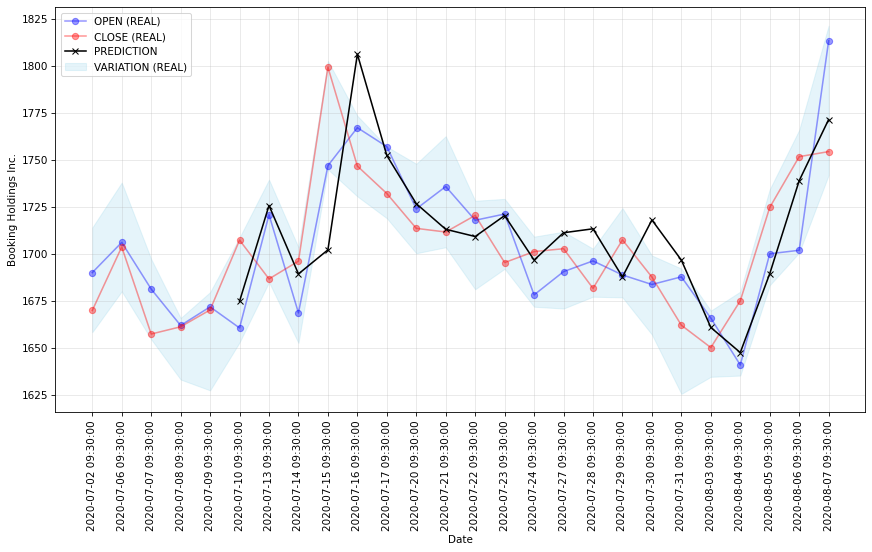

In [30]:
for stock in metadata['STOCKS_TO_PREDICT']:   
    # Generate DataFrame with actual stock prices
    Y = pd.DataFrame(columns=['OPEN','CLOSE','LOW','HIGH'], index=df_test.index)
    for col in Y.columns:
        column = stock + '_' + col
        Y[col] = df_test[column]
        
    # * * * * * * * OPEN prices * * * * * * * 
    Y_pred = get_predictions(stock=stock, var='OPEN', df=df_test)
        

    # Plot comparison
    compare_predictions(instrument=SP500_const_wgts[SP500_const_wgts['SYMBOL'] == stock]['COMPANY'].values[0], Y=Y, Y_pred=Y_pred)
    
    flush_memory()

From the figure above we observe how the predictions (black line with crosses) closely follow the actual values and trends of the open prices of the target (blue line with solid circles).

<a id='discussion'></a>

---

## Discusion

Different single-layer RNNs with Long Short Term Memory (LSTM) cells were implemented to predict next day's open price of Booking Holdings Inc. From this exercise we conclude that forecasting the US stock market is possible, and paves the way for further iterations with refinements and improvements of the models used in this notebook.

Thanks to the parallelization of TensorFlow using Graphic Processing Units (GPUs) further improvements can be made along the following lines:

1. Increase the layer of the RNN for further resolution.
2. A deeper hyperparameter scan for fine-tunning RNNs.
3. Include more variables during the training phase, which is equivalent to decreasing the correlation threshold.

Other improvements that can be made include:

1. Feature selection: by performing a more complex, non-linear analysis of the variables.
2. Using different loss functions during training that take into account not only differences between values but also take into account trends (slopes) of time series.